<a href="https://colab.research.google.com/github/TwistedMat/Zillow-Zestimate-Regression/blob/main/ZillowZestimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import altair as alt
from scipy import stats
import missingno as msno
from datetime import datetime
matplotlib.style.use('ggplot')
pd.set_option('display.max_columns', None)
%matplotlib inline

# Importing dataset and merging

In [10]:
traindf = pd.read_csv('/content/train_2017.csv', parse_dates=["transactiondate"])
propertiesdf = pd.read_csv('/content/properties_2017.csv',low_memory=False)

In [11]:
# Shape of the datasets
print('Shape of properties 2017: ', propertiesdf.shape)
print('Shape of train 2017: ', traindf.shape)

Shape of properties 2017:  (2985217, 58)
Shape of train 2017:  (77613, 3)


In [18]:
mergeddf = pd.merge(traindf,propertiesdf,on="parcelid",how="left")
mergeddf.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,14297519,0.025595,2017-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13
1,17052889,0.055619,2017-01-01,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13
2,14186244,0.005383,2017-01-01,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13
3,12177905,-0.103410,2017-01-01,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13
4,10887214,0.006940,2017-01-01,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13


In [19]:
mergeddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   parcelid                      77613 non-null  int64         
 1   logerror                      77613 non-null  float64       
 2   transactiondate               77613 non-null  datetime64[ns]
 3   airconditioningtypeid         25007 non-null  float64       
 4   architecturalstyletypeid      207 non-null    float64       
 5   basementsqft                  50 non-null     float64       
 6   bathroomcnt                   77579 non-null  float64       
 7   bedroomcnt                    77579 non-null  float64       
 8   buildingclasstypeid           15 non-null     float64       
 9   buildingqualitytypeid         49809 non-null  float64       
 10  calculatedbathnbr             76963 non-null  float64       
 11  decktypeid                  

In [20]:
mergeddf.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,7.761300e+04,77613.000000,25007.000000,207.000000,50.000000,77579.000000,77579.000000,15.000000,49809.000000,76963.000000,614.0,6037.000000,77378.000000,73923.000000,42.000000,3027.000000,6037.000000,386.000000,77579.000000,8289.000000,76963.000000,25520.000000,25520.000000,49571.000000,7.757900e+04,7.757900e+04,6.932100e+04,16174.0,869.000000,465.0,1074.0,15079.0,77579.000000,7.757900e+04,76107.000000,77579.000000,30974.000000,77529.000000,77579.000000,50.0,10106.000000,223.000000,50703.000000,2393.000000,70.000000,77309.000000,17599.000000,7.746400e+04,7.757800e+04,77579.0,7.757700e+04,77574.000000,2900.000000,7.733200e+04
mean,1.300781e+07,0.016755,1.812013,7.386473,679.720000,2.298496,3.053223,3.933333,6.533779,2.316392,66.0,1366.165314,1784.935421,1760.284553,1388.761905,2354.491245,1381.388935,2082.500000,6048.814151,1.191217,2.250107,1.815282,350.047061,3.921749,3.400837e+07,-1.182037e+08,2.997344e+04,1.0,517.930955,1.0,1.0,1.0,261.824476,6.049124e+07,33683.055107,2534.514933,187725.110544,96586.692812,1.476276,7.0,1.009598,6.040359,1.110309,305.460928,216.385714,1968.611507,1.434286,1.892811e+05,4.901506e+05,2016.0,3.011515e+05,5995.961788,14.088276,6.049667e+13
std,3.518717e+06,0.170887,2.965768,2.728030,689.703546,0.996732,1.140480,0.258199,1.722062,0.979689,0.0,670.701336,954.250373,934.352566,122.220874,1186.985442,725.792665,1240.382784,20.747252,0.490980,0.966492,0.588340,261.646070,3.594780,2.652873e+05,3.594085e+05,1.233050e+05,0.0,156.569664,0.0,0.0,0.0,5.141596,2.058962e+05,47211.780350,801.447913,165045.086058,3793.552065,2.823686,0.0,0.118572,0.556035,1.169967,238.735241,190.177514,23.793171,0.544515,2.304107e+05,6.537979e+05,0.0,4.927249e+05,7628.859728,2.181281,1.533339e+12
min,1.071186e+07,-4.655420,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13
25%,1.153821e+07,-0.024325,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,8.417925e+04,2.068985e+05,2016.0,8.529300e+04,2712.630000,14.000000,6.037311e+13
50%,1.253004e+07,0.006670,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000000,1259.000000,1812.500000,6037.000000,1.000000,2.000000,2.000000,436.000000,2.000000,3.402200e+07,-1.181810e+08,7.206000e+03,1.0,500.000000,1.0,

# Visualizing Datatypes

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Variable Type'),
 Text(0.5, 1.0, 'Variables Count Across Datatype')]

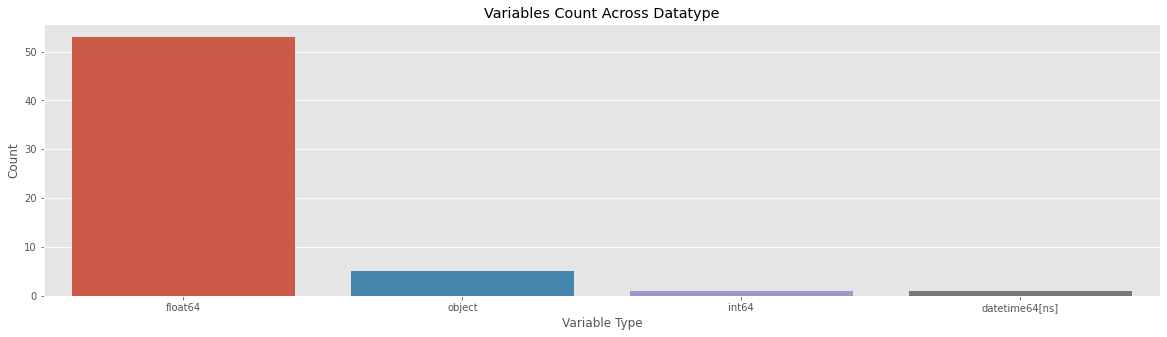

In [21]:
dataTypeDf = pd.DataFrame(mergeddf.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

In [22]:
dataTypeDf

,variableType,count
0,float64,53
1,object,5
2,int64,1
3,datetime64[ns],1


In [36]:
list(mergeddf.select_dtypes(include=['object']).columns)

['hashottuborspa',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'taxdelinquencyflag']

In [53]:
catcols = [col for col in mergeddf.columns if (('id' in col) or ('code' in col) or ('flag' in col) or ('desc' in col)) and col!='parcelid']
catcols

['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'decktypeid',
 'heatingorsystemtypeid',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'storytypeid',
 'typeconstructiontypeid',
 'fireplaceflag',
 'taxdelinquencyflag']

In [57]:
mergeddf[catcols] = mergeddf[catcols].astype('object')

In [58]:
dataTypeDf = pd.DataFrame(mergeddf.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
dataTypeDf

,variableType,count
0,float64,37
1,object,21
2,int64,1
3,datetime64[ns],1


# Visualizing Data Distributions

In [107]:
# plt.figure(figsize=(15,10))
# plt.title('Log Error',fontsize=20,color='red')
# plt.ylabel('Count')
# plt.xlabel('logerror')
# plt.hist(mergeddf['logerror'],bins='auto')

In [106]:
import plotly.express as px
fig = px.histogram(mergeddf,x='logerror',labels={'x':'log error','y':'Count'},title='Log Error', width=1024)
fig.update_layout(
    title_font_family="Times New Roman",
    title_font_color="red",
    title_x=0.45,
    title_font_size=20)
fig.show()

In [108]:
# abslogerror = mergeddf.logerror.abs()
# plt.figure(figsize=(15,10))
# plt.title('Absolute Log Error',fontsize=20,color='red')
# plt.ylabel('Count')
# plt.xlabel('logerror')
# plt.hist(abslogerror,bins='auto')

In [105]:
abslogerror = mergeddf.logerror.abs()
fig = px.histogram(x=abslogerror,labels={'x':'abs log error','y':'Count'},title='Absolute Log Error', width=1024)
fig.update_layout(
    title_font_family="Times New Roman",
    title_font_color="red",
    title_x=0.45,
    title_font_size=20)
fig.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15501dea90>,
      dtype=object)

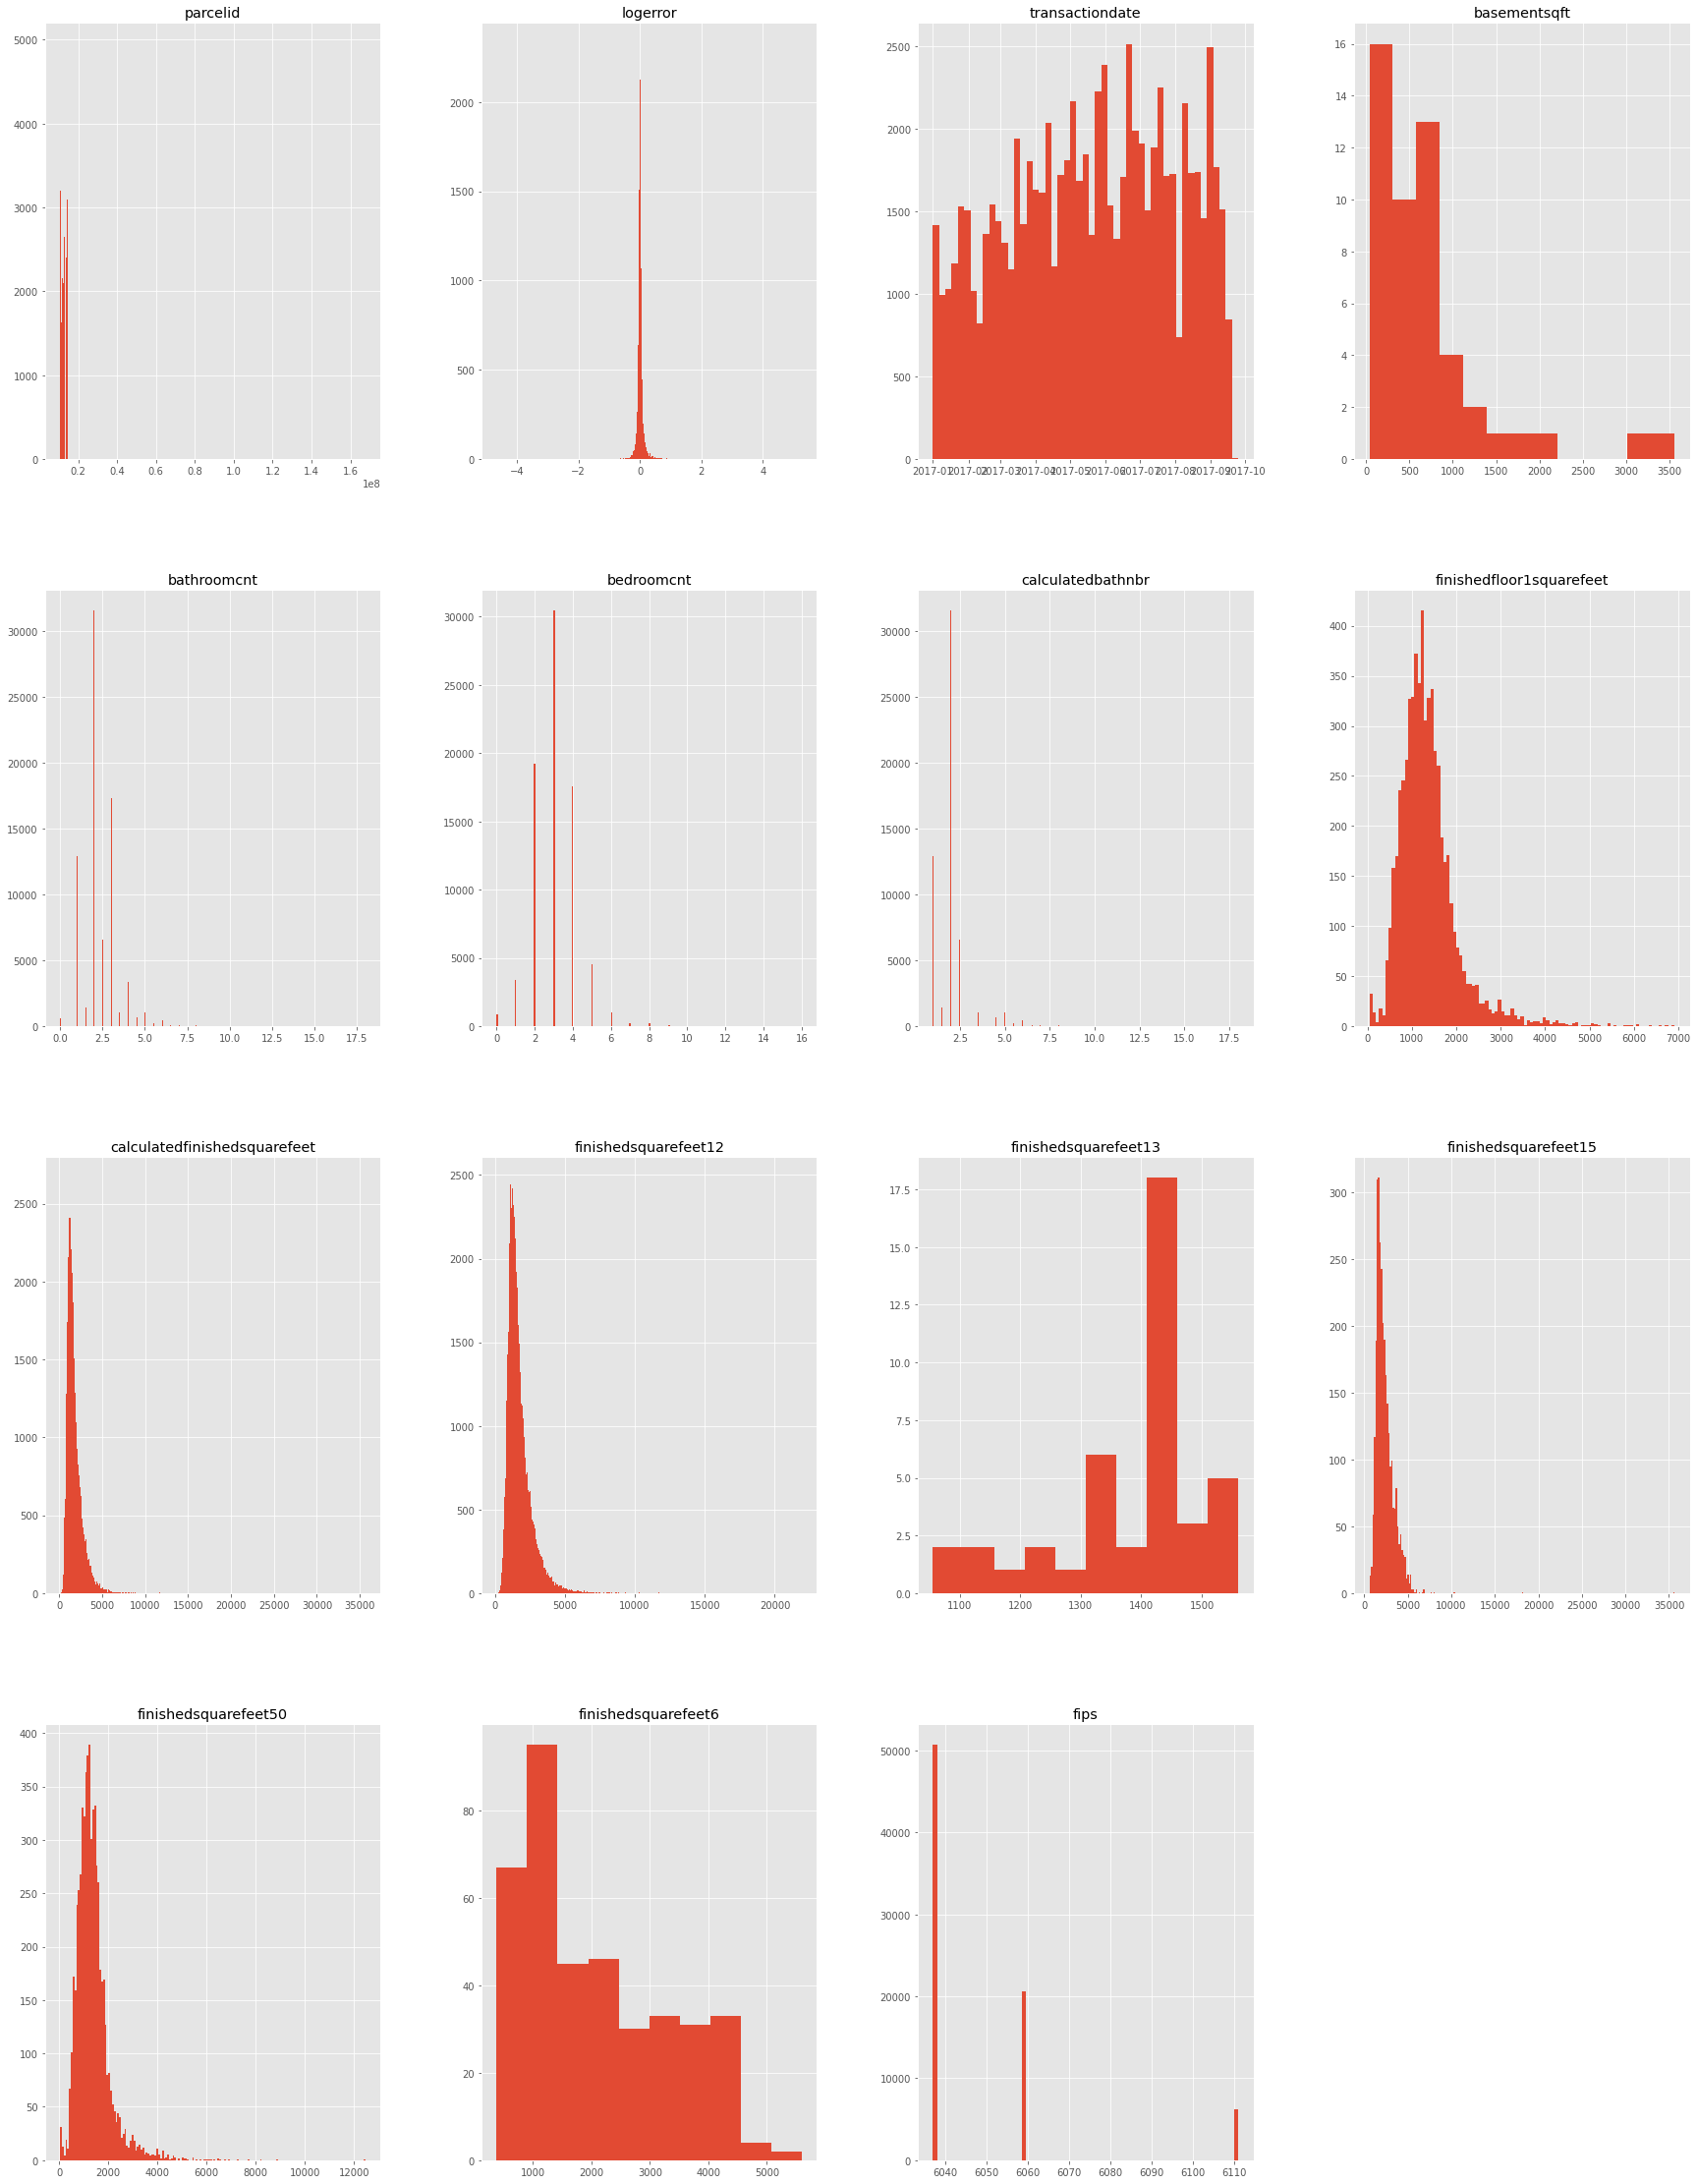

In [124]:
params = {'axes.titlesize':'20'}
mergeddf.hist(column = mergeddf.columns.to_list()[:20], bins = 'auto',figsize=(30,40))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f159cdb5c10>,
      dtype=object)

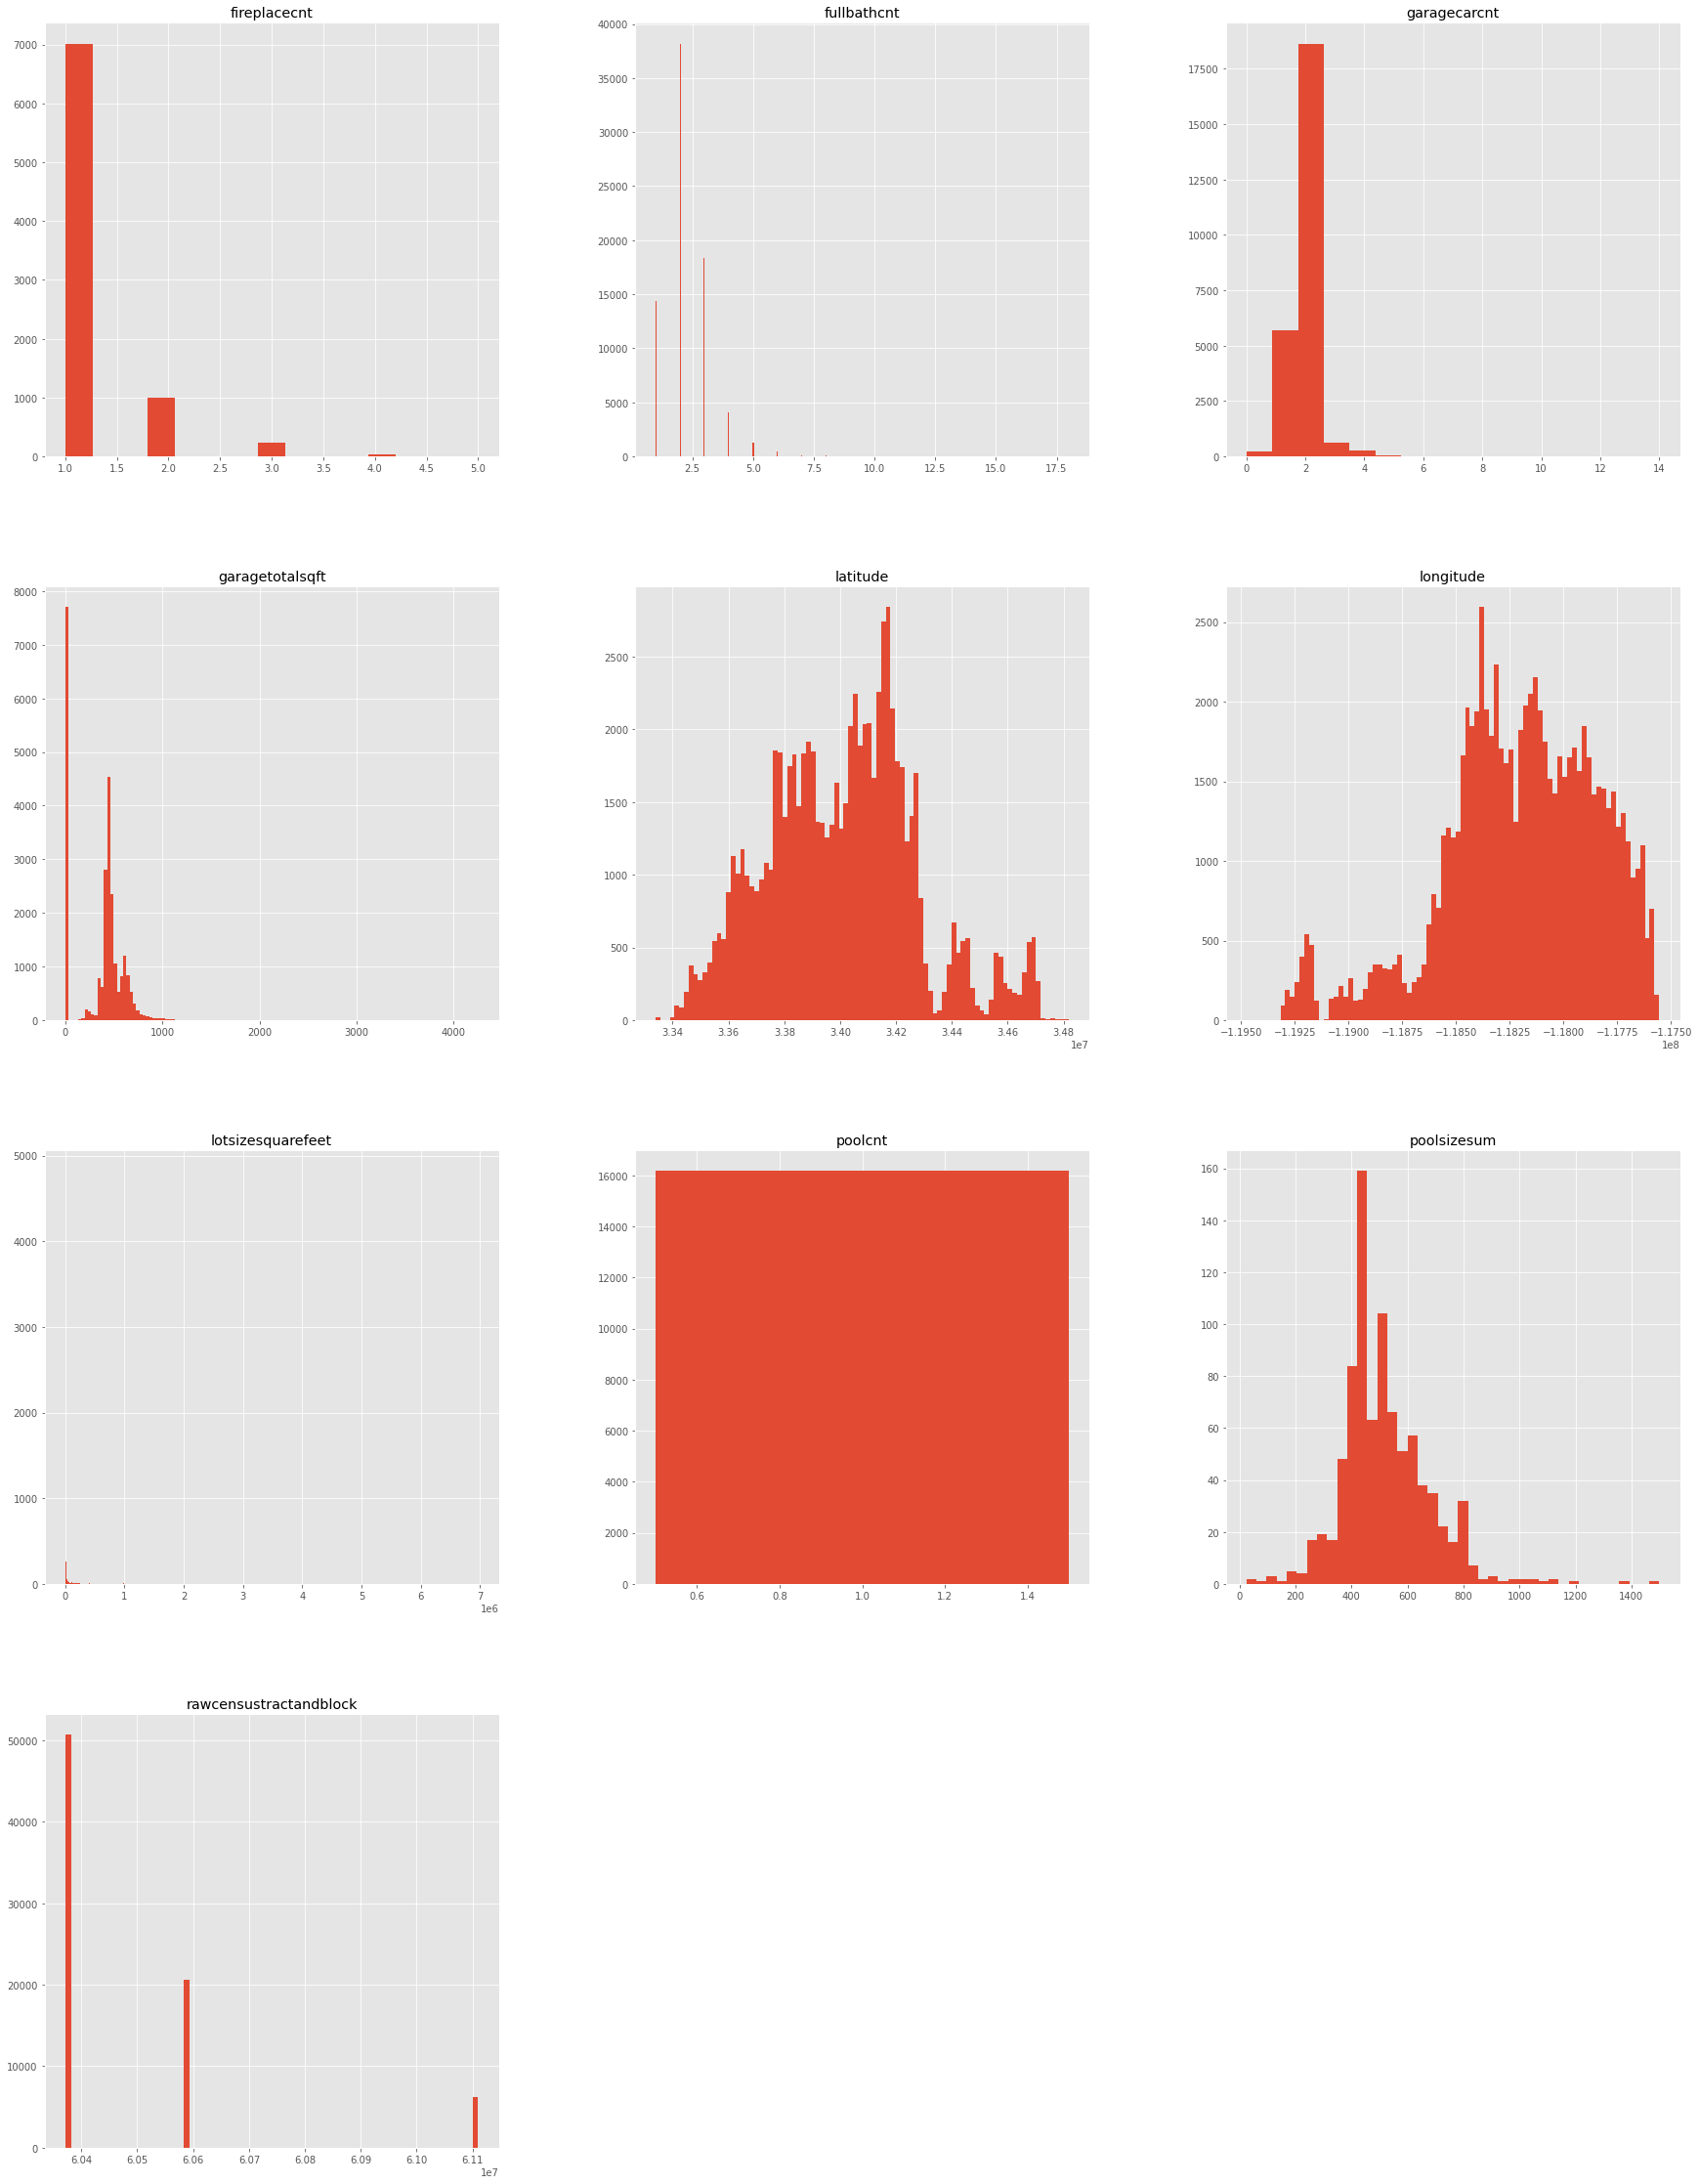

In [122]:
params = {'axes.titlesize':'20'}
mergeddf.hist(column = mergeddf.columns.to_list()[20:40], bins = 'auto',figsize=(30,40))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1576e98090>,
      dtype=object)

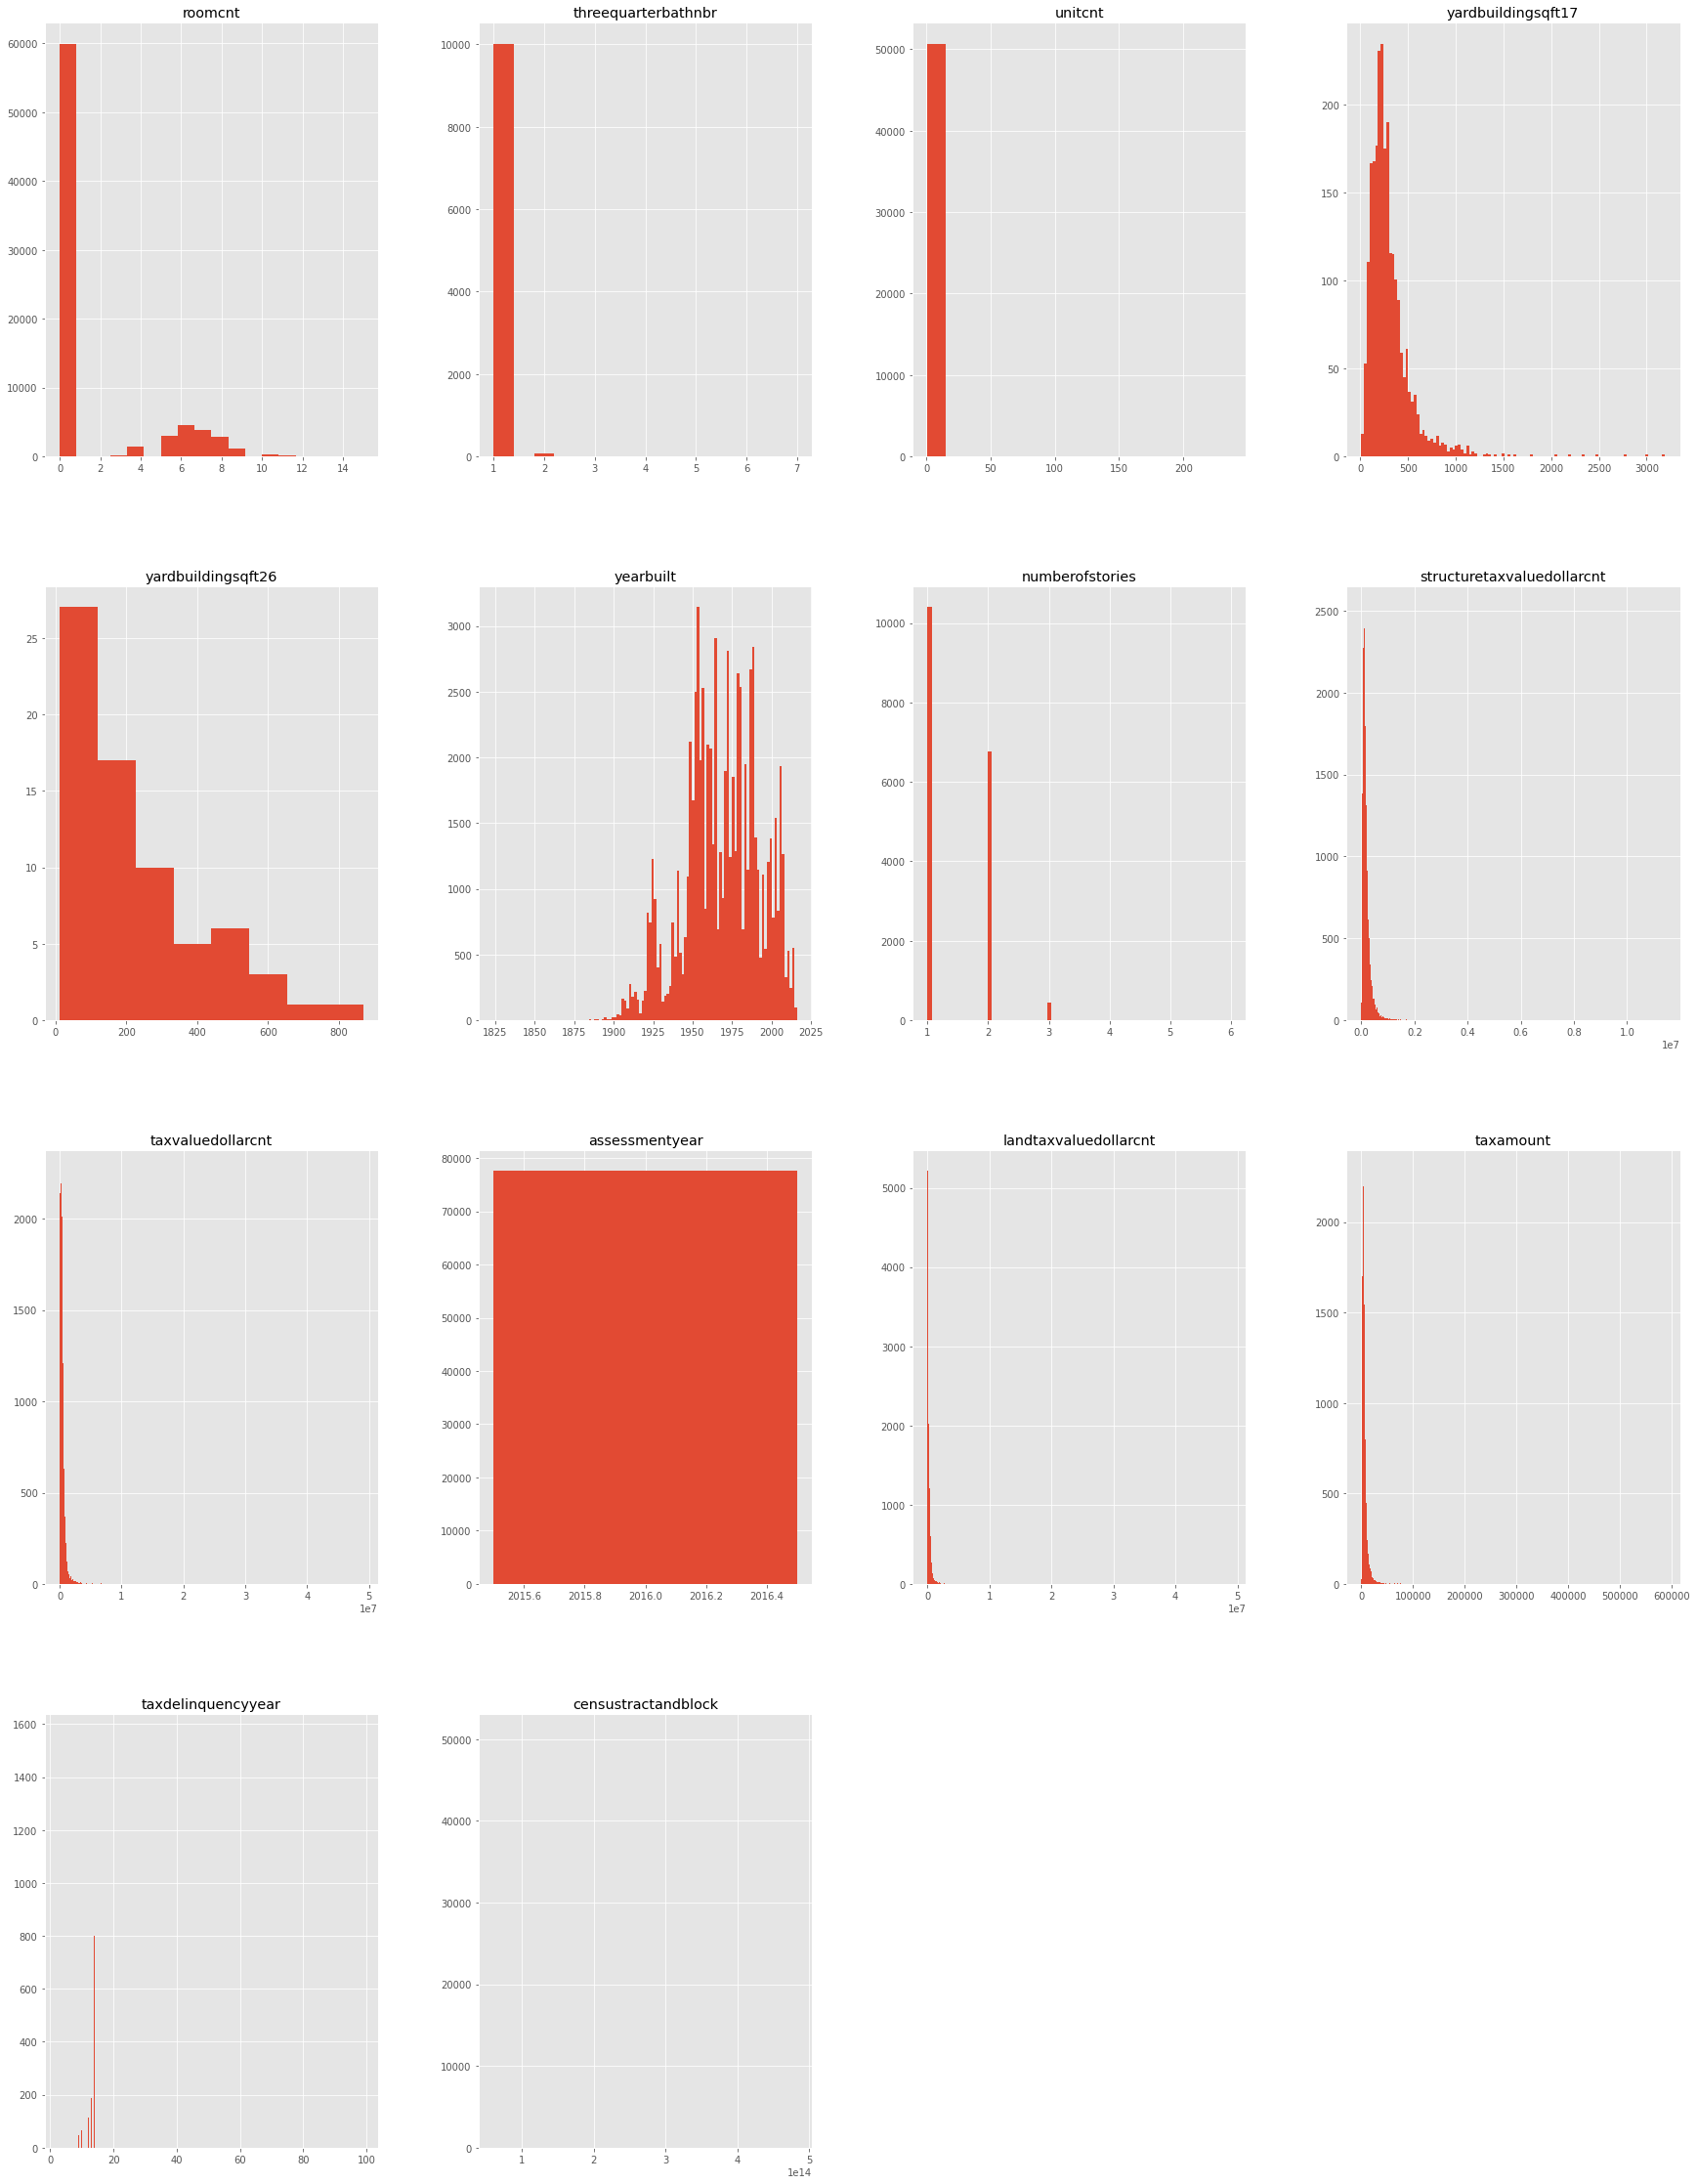

In [123]:
params = {'axes.titlesize':'20'}
mergeddf.hist(column = mergeddf.columns.to_list()[40:], bins = 'auto',figsize=(30,40))

# Mean Log Error over time

In [133]:
logerror_mon = mergeddf.groupby(pd.Grouper(key='transactiondate',freq='MS')).mean()['logerror']
px.line(logerror_mon,markers=True)

# Feature elimination based on missing values

In [150]:
missing_df = mergeddf.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

In [151]:
fig = px.bar(missing_df, x="missing_count", y="column_name", orientation='h',width=1200,height=1024)
fig.update_traces(marker_color='crimson')
fig.show()

In [178]:
most_missing_data = mergeddf.columns[mergeddf.isnull().mean()*100 > 95]
list(most_missing_data)

['architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'decktypeid',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet6',
 'hashottuborspa',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'storytypeid',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear']

In [179]:
len(most_missing_data)

18

In [180]:

len(missing_df.query('missing_count>60000'))

25

#### calculatedfinishedsqfeet has least number of missing values for sq feet info and the rest finishedsqfeet related columns have more than 80% nulls. These are selected to be dropped.
#### Also, bathroomcnt has lesser nulls than calculatedbathnbr and fullbathcnt and seems to hold similar info as per the data dictionary. Can be selected for removal too. 
#### Also removing other columns which have a ton of null columns (>95%) and don't seem to have any information regarding them. 

In [186]:
drop_cols = ['finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'calculatedbathnbr',
 'fullbathcnt',
 'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'decktypeid',
 'fireplacecnt',
  'threequarterbathnbr',
  'typeconstructiontypeid',
  'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'storytypeid',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'yardbuildingsqft17',
 'yardbuildingsqft26',]

In [187]:
postdropdf = mergeddf.drop(labels=drop_cols,axis=1)
postdropdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   parcelid                      77613 non-null  int64         
 1   logerror                      77613 non-null  float64       
 2   transactiondate               77613 non-null  datetime64[ns]
 3   airconditioningtypeid         25007 non-null  object        
 4   bathroomcnt                   77579 non-null  float64       
 5   bedroomcnt                    77579 non-null  float64       
 6   buildingqualitytypeid         49809 non-null  object        
 7   calculatedfinishedsquarefeet  77378 non-null  float64       
 8   finishedsquarefeet12          73923 non-null  float64       
 9   fips                          77579 non-null  float64       
 10  garagecarcnt                  25520 non-null  float64       
 11  garagetotalsqft             